In [1]:
import sys
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append('../')

In [2]:
from SwotDiag.diagnosis import *

### Standard SWOT product (2 km, L3)

In [3]:
file = '../Samples/SWOT_L3_LR_SSH_Expert_001_155_20230726T173637_20230726T182803_v1.0.2_fcs.nc'
swot = xr.open_dataset(file)

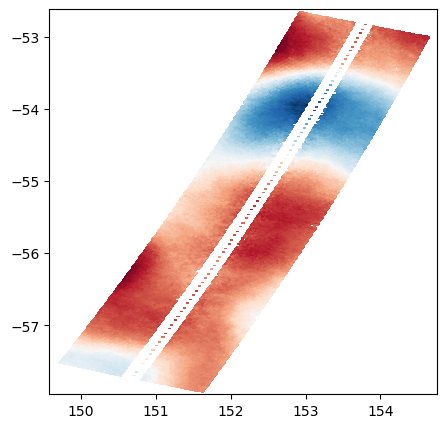

In [4]:
plt.figure(figsize = (5,5))

plt.pcolormesh(swot.longitude, swot.latitude, swot.ssha, cmap = 'RdBu_r')

#### General utilization

In [15]:
params = dict(derivative = 'fit', # Derivative obtained by the fitting method instead of point difference
          n = 13, # 13*13 point kernels
          min_valid_points = 0.75, # Ratio of valid points to compute the derivative (e.g. 75% valid points are necessary to compute the derivatives, useful to avoid boundary effects)
          cyclostrophy = 'GW', # Cyclogeostrophic currents are computed using the wind-gradient balance
          avoid_negative = False, # Parameter that avoid negative values in the SQRT using the GW formulation (leading to invalid values in the solutions)
          second_derivative = 'dxdy', # The second derivative is obtained by point-difference the first derivative (obtained by surface fitting method), rather than from the surface curvature. I noticed that it reduces the noise. 
          kernel = 'circular', # can be circular or a square, the shape of the kernel

)

## Diagnostics from original SSH
diag = compute_ocean_diagnostics_from_eta(swot.ssha + swot.mdt, swot.longitude, swot.latitude, **params)

Fitting derivatives on 20079 points (13*13 points kernel): 100%|██████████| 291/291 [00:00<00:00, 466.97it/s]
/home/tra198/DEV/SwotDiag/Notebooks/../SwotDiag/diagnosis.py:176: RuntimeWarning: invalid value encountered in sqrt
  ucg = 2*ug/(1+np.sqrt(c))
/home/tra198/DEV/SwotDiag/Notebooks/../SwotDiag/diagnosis.py:177: RuntimeWarning: invalid value encountered in sqrt
  vcg = 2*vg/(1+np.sqrt(c))


In [16]:
### Adding the computed diagnostics to the original xarray dataset

dims = swot.ugos.dims
swot = swot.assign(ugos_csiro = (dims, diag['ug']), vgos_csiro = (dims, diag['vg']), 
                   ucgos_csiro = (dims, diag['ucg']), vcgos_csiro = (dims, diag['vcg']),
                  zeta_csiro = (dims, diag['zeta']), sr_csiro = (dims, diag['S']), OW_csiro = (dims, diag['OW']))

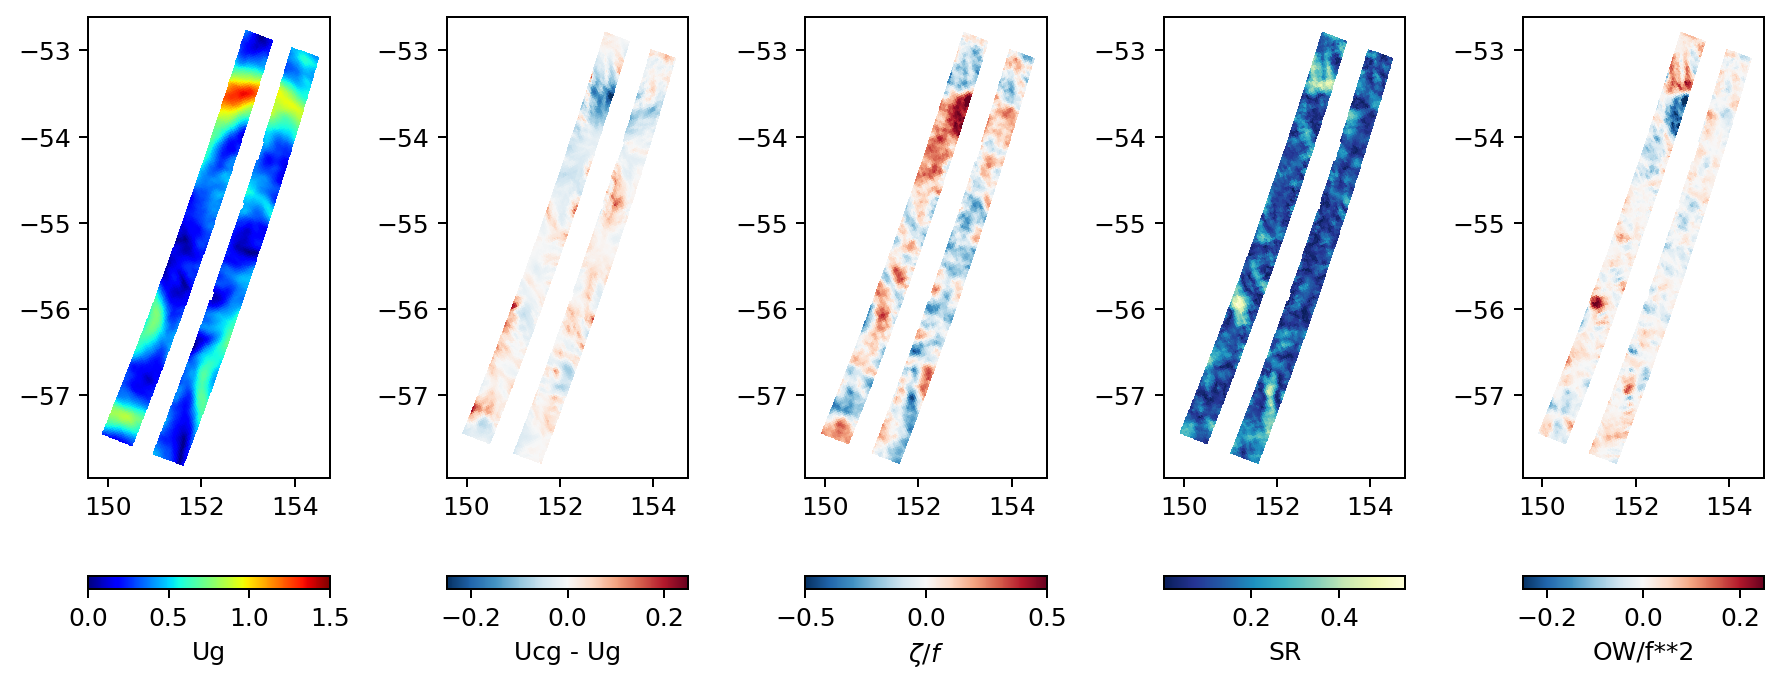

In [18]:
Ug = np.sqrt(swot.ugos_csiro**2 + swot.vgos_csiro**2)
Ucg = np.sqrt(swot.ucgos_csiro**2 + swot.vcgos_csiro**2)

plt.figure(figsize = (10,4), dpi = 180)

plt.subplot(151)
plt.pcolormesh(swot.longitude, swot.latitude, Ug, cmap = 'jet')
plt.colorbar(orientation = 'horizontal', label = r'Ug')
plt.clim(0,1.5)

plt.subplot(152)
plt.pcolormesh(swot.longitude, swot.latitude, Ucg - Ug, cmap = 'RdBu_r')
plt.colorbar(orientation = 'horizontal', label = r'Ucg - Ug')
plt.clim(-0.25,0.25)

plt.subplot(153)
plt.pcolormesh(swot.longitude, swot.latitude, swot.zeta_csiro, cmap = 'RdBu_r')
plt.colorbar(orientation = 'horizontal', label = r'$\zeta/f$')
plt.clim(-0.5,0.5)

plt.subplot(154)
plt.pcolormesh(swot.longitude, swot.latitude, swot.sr_csiro, cmap = 'YlGnBu_r')
plt.colorbar(orientation = 'horizontal', label = 'SR')
# plt.clim(0,0.5)

plt.subplot(155)
plt.pcolormesh(swot.longitude, swot.latitude, swot.OW_csiro, cmap = 'RdBu_r')
plt.colorbar(orientation = 'horizontal', label = 'OW/f**2')
plt.clim(-0.25,0.25)

plt.tight_layout()